In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import rasterstats

from shapely import wkt
from libpysal import weights

from cycler import cycler
from matplotlib import pyplot as plt

# global plotting settings
plt.style.use(['ggplot'])


default_cycler = (plt.rcParams['axes.prop_cycle'][:4]  +
                  cycler(linestyle=['-', '--', ':', '-.']))

plt.rcParams.update({'axes.grid' : True, 
                     'axes.facecolor' : 'white', 
                     'axes.edgecolor' : '.15',
                     'grid.color' : '.8',
                     'axes.prop_cycle' : default_cycler,
                     'figure.figsize' : (15, 5)
                    })


/home/otto/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/otto/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
litho = gpd.read_file('litho0.geojson')

In [3]:
mask = (litho['contact1']==True) | (litho['contact2']==True)

In [65]:
xstart = 10
xstop = 25
ystart = 17
ystop = 30

litho_sahara = litho.cx[xstart:xstop,ystart:ystop]

In [12]:
litho_sahara.loc[mask].geometry.to_file('sahara.shp')

In [13]:
landr = rasterstats.point_query('sahara.shp', './umd_landcover_class_hd.asc', interpolate='nearest')

In [15]:
modis_path = os.path.join('./MOD11C3v6_LST_K_day&night_2000_2020_moclim/LSTdaytime_nc/MOD11C3v6_LST_K_daytime_2000_2020_MONTH_01.nc')

modisr = rasterstats.point_query('sahara.shp', modis_path, interpolate='nearest')

In [24]:
modf = gpd.GeoDataFrame(modisr, 
                        geometry=gpd.GeoSeries.from_file('sahara.shp'), 
                        crs='epsg:4326', columns=['LST_01'])

In [66]:
litho_sahara = litho_sahara.sjoin(modf, how='inner')

In [67]:
maskvolc = litho_sahara['contact1']==True
masksed = litho_sahara['contact2']==True

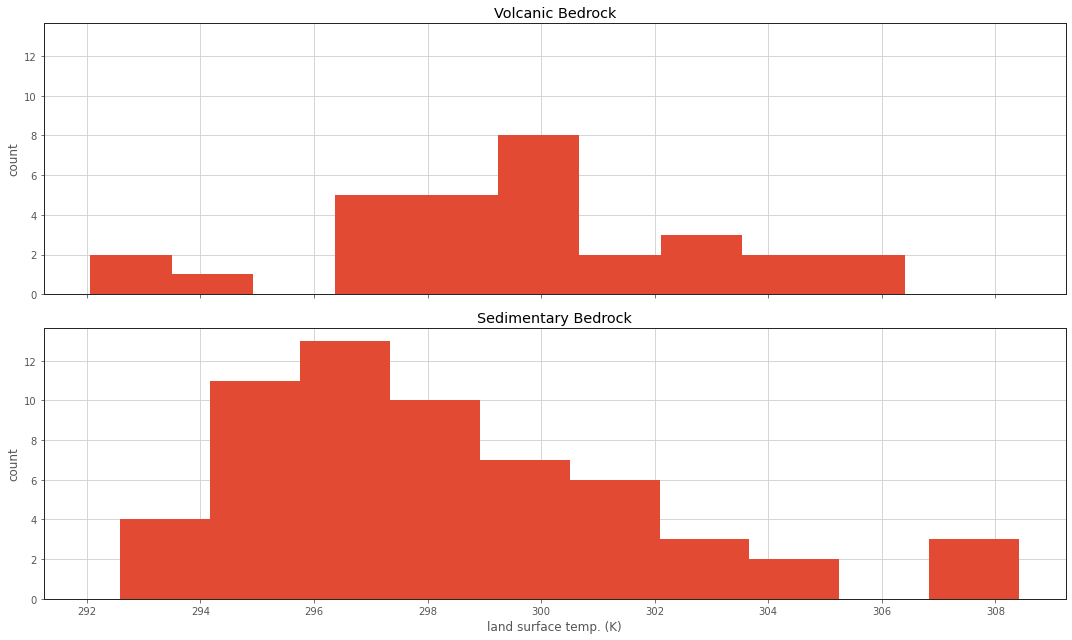

In [81]:
fig, ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(15,9))


ax[0].hist(litho_sahara.loc[maskvolc].LST_01)
ax[0].set(ylabel='count', title='Volcanic Bedrock')
ax[1].hist(litho_sahara.loc[masksed].LST_01)
ax[1].set(ylabel='count',title='Sedimentary Bedrock', xlabel='land surface temp. (K)')

plt.tight_layout()

In [18]:
litho.cx[xstart:xstop,ystart:ystop].loc[mask, 'modis_day'] = modisr

/home/otto/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/otto/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.cx[xstart:xstop, ystart:ystop].plot(color='white', edgecolor='black')

modis.MOD11C3_006_LST_Day_CMG.plot(ax=ax)
# land.plot(ax=ax)

litho.cx[xstart:xstop, ystart:ystop].loc[mask].plot(column='glim', legend=True, ax=ax, cmap='OrRd', markersize=6)


ax.set_xlim(xstart, xstop)
ax.set_ylim(ystart,ystop)

In [ ]:
points = litho.geometry.to_json()

In [5]:
litho.geometry.to_file('litho.shp')

In [6]:
landr = rasterstats.point_query('litho.shp', './umd_landcover_class_hd.asc', interpolate='nearest')

In [ ]:
modis_path = os.path.join('./MOD11C3v6_LST_K_day&night_2000_2020_moclim/LSTdaytime_nc/MOD11C3v6_LST_K_daytime_2000_2020_MONTH_01.nc')

modisr = rasterstats.point_query('litho.shp', modis_path, interpolate='nearest')

In [4]:
landr = rasterstats.point_query(points, './umd_landcover_class_hd.asc', interpolate='nearest')

<AxesSubplot:>

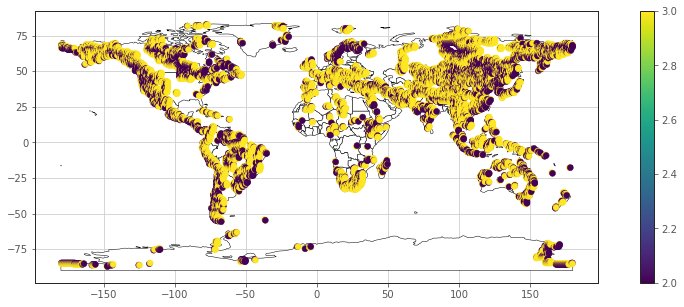

In [69]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')

mask = (litho['contact1']==1) | (litho['contact2']==1)
litho.loc[mask].plot(column='glim', legend=True, ax=ax)

## Cleaning original litho file

In [53]:
litho = litho.replace([None], np.nan)
litho.loc[:, ['contact1', 'contact2']] = litho.loc[:, ['contact1', 'contact2']].replace('1', 1)

In [56]:
litho.loc[:, ['contact1', 'contact2']] = litho.loc[:, ['contact1', 'contact2']].replace(np.nan, 0)

In [54]:
litho.iloc[42]['contact2'] == '1'

False

In [62]:
litho = litho.drop(columns='contact')